### Solve 2959 using rewriting/substitutions in equations

This notebook solves SAT for https://github.com/VeriFIT/smt-bench/blob/master/formulae/slog/slog_stranger_2959_sink.smt2 manually using algos from Noodler and by modifying the original equation system into an equivalent one with fewer equations.

In [1]:
import noodler

In [2]:
filename = "../benchmarks/slog/slog_stranger_2959_sink.smt2"
parser = noodler.parser.SmtlibParserHackAbc(filename)
orig = parser.parse_query()

Here is the list of equations and graph showing dependencies between variables. In the following, we rewrite the equations highlighted with the green box into one equation and try to solve it in one shot.

In [3]:
graph = '<img src="Dependency-graph-augmented.png" alt="Drawing" style="width: 300px;"/>'
eq_str = "<br />".join([e.__str__() for e in orig.equations])

noodler.utils.display_inline(eq_str, graph, per_row=2)

In [4]:
from noodler.sequery import MultiSEQuery
from noodler.utils import show_automata
from noodler import StringEquation

In [5]:
def merge_equations(query, substitute_ids):
    """
    Remove (by substitution) equations from MultiSEQuery.
    
    Builds an equivalent query to ``query`` that does not contain
    equations given by ids in ``substitute_ids``. These equations
    must be assignments (e.g. of the form `xᵢ = y₁y₂...`). To maintain
    equivalence, all occurences of `xᵢ` are substituted with `y₁y₂...`
    and the constraints (if not equivalent to Σ*) are propagated to
    constraints for the corresponding (left-side) variables.
    
    Correct for straightline fragment.
    
    TODO
    ----
    propagate constraints
    
    Returns
    -------
    MultiSEQuery equivalent to ``query`.
    """
    # Check that all equations are assignments
    # and that the corresponding constraints are Σ*
    for eq_id in substitute_ids:
        eq = query.equations[eq_id]
        assert len(eq.left) == 1 # assignment
        
        var = eq.left[0]
        constr = query.aut_constraints[var]
        assert constr.num_useful_states() == 1
        assert len(constr.final_states()) == 1
    
    substitute_vars = [query.equations[eq_id].left[0] for eq_id in substitute_ids]
    
    # Copy usable parts
    working_eq = [noodler.StringEquation(eq.left, eq.right.copy()) for eq in query.equations]
    res_eq = []
    res_constr = {var : query.aut_constraints[var].copy() for var in query.aut_constraints if var not in substitute_vars}
    
    # Substitute
    for eq_id in range(len(working_eq)):
        eq = working_eq[eq_id]
        # If not to removed, add to result
        if eq_id not in substitute_ids:
            res_eq.append(eq)
            continue
        
        # Else substitute
        var, right = eq.left[0], eq.right
        for succ_i  in range(eq_id+1, len(working_eq)):
            succ_eq = working_eq[succ_i]
            if var not in succ_eq.right:
                continue
            # Else substitute `right` for var
            new_succ_right = []
            for v in succ_eq.right:
                if v == var:
                    new_succ_right.extend(right)
                else:
                    new_succ_right.append(v)
            working_eq[succ_i] = StringEquation(succ_eq.left, new_succ_right)
    
    res = MultiSEQuery(res_eq, res_constr)
    return res

q = merge_equations(orig, range(8,15))

In [6]:
q.equations

[StringEquation: ['x_8'] = ['literal_7', 'sigmaStar_2'],
 StringEquation: ['x_10'] = ['x_8', 'literal_9'],
 StringEquation: ['x_12'] = ['x_10', 'sigmaStar_1'],
 StringEquation: ['x_15'] = ['x_12', 'literal_13'],
 StringEquation: ['x_17'] = ['x_15', 'sigmaStar_6'],
 StringEquation: ['x_21'] = ['x_17', 'literal_19'],
 StringEquation: ['x_24'] = ['x_21', 'literal_18'],
 StringEquation: ['x_25'] = ['x_24', 'literal_23'],
 StringEquation: ['x_39'] = ['literal_22', 'x_25', 'literal_27', 'x_25', 'literal_32', 'x_25', 'literal_30', 'x_25', 'literal_35'],
 StringEquation: ['x_41'] = ['x_39', 'literal_40']]

In [7]:
orig.equations

[StringEquation: ['x_8'] = ['literal_7', 'sigmaStar_2'],
 StringEquation: ['x_10'] = ['x_8', 'literal_9'],
 StringEquation: ['x_12'] = ['x_10', 'sigmaStar_1'],
 StringEquation: ['x_15'] = ['x_12', 'literal_13'],
 StringEquation: ['x_17'] = ['x_15', 'sigmaStar_6'],
 StringEquation: ['x_21'] = ['x_17', 'literal_19'],
 StringEquation: ['x_24'] = ['x_21', 'literal_18'],
 StringEquation: ['x_25'] = ['x_24', 'literal_23'],
 StringEquation: ['x_26'] = ['literal_22', 'x_25'],
 StringEquation: ['x_29'] = ['x_26', 'literal_27'],
 StringEquation: ['x_31'] = ['x_29', 'x_25'],
 StringEquation: ['x_33'] = ['literal_30', 'x_25'],
 StringEquation: ['x_34'] = ['x_31', 'literal_32'],
 StringEquation: ['x_36'] = ['x_33', 'literal_35'],
 StringEquation: ['x_37'] = ['x_34', 'x_25'],
 StringEquation: ['x_39'] = ['x_37', 'x_36'],
 StringEquation: ['x_41'] = ['x_39', 'literal_40']]

In [8]:
machine = noodler.noodler.StraightlineNoodleMachine(q)
machine.is_sat(verbose=False)

True

Here we investigate what takes that long in level 8. Is it the product? Noodlification? 

In [9]:
from noodler import SegAut, Aut
from noodler.algos import eps_segmentation

In [10]:
n = machine.noodlers[-2]
query = n.query
query.eq

StringEquation: ['literal_22', 'x_25', 'literal_27', 'x_25', 'literal_32', 'x_25', 'literal_30', 'x_25', 'literal_35'] = ['x_39']

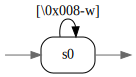

In [11]:
machine.noodlers[-2].query.constraints["x_25"].display()

### It's not the product!

In [12]:
%%timeit
left: SegAut = query.seg_aut("left")
right: Aut = query.proper_aut("right")
assert left.alphabet() == right.alphabet()
product: SegAut = noodler.eps_preserving_product(left, right, history=True)

21.4 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
left: SegAut = query.seg_aut("left")
right: Aut = query.proper_aut("right")
assert left.alphabet() == right.alphabet()
product: SegAut = noodler.eps_preserving_product(left, right, history=True)

### Investigate number of noodles
We know that we do not care about what is in literals. Can we abstract somehow?

In [ ]:
%%timeit
noodler.noodlify(product)

In [ ]:
segmentation = eps_segmentation(product)
segmentation

In [ ]:
n_c = 1
for s in segmentation.values():
    n_c *= len(s)
print(n_c)

We have 5832 possible noodles, but only one is non-empty. Can we detect it somehow by a smarter algo? Also, we should be able to merge noodles that differ only in how literals are traversed.

We are basically only interested in the possible constraints for `x_25` which are the segments `1,3,5,7`. We can see here that the last occurence of `x_25` has only one outgoing eps-transition.

In [ ]:
for tr in segmentation[6]:
    print(product.get_state_name(product.src_of(tr)), product.get_state_name(product.dst_of(tr)))

In [ ]:
noodler.split_segment_aut(product)[7].display()

In [ ]:
def is_reachable(aut, tr, tr_from):
    todo = [aut.dst_of(tr_from)]
    visited = {aut.dst_of(tr_from)}

## Noodle-DAG

The idea of a noodle tree is to build a DAG whose nodes are ε-transitions (their ids) and there is an edge between tr₁ and tr₂ if and only if tr₂ is reachable from tr₁ with only non-ε transitions. That is, the transition are on the frontier of one segment (one at the beginning and one at the end).

### Intended use
The noodle DAG can be used to choose only viable noodles for further investigation.

### Further suggestions

#### Automata on edges
The edges ofn the noodle DAG can also contain the corresponding sub-automaton (or its equivalent variant). This can be used to the following.
 1. Directly build noodles from the noodle-DAG (but the noodles would not be needed any more).
 2. Make some kind of unification common to several noodles.
 3. Unify/merge noodles for one segment that 1) end in the same state of product, or put easier in the same transition, and 2) describe the same language (is this needed? not always). See the example here where we have 8 out of 9 noodles that end in the same state.
 7337
 
 4. ... ?

#### Use backward edges as well
This might be useful for the unification mentioned above.

### Ideas
#### Approximation based on noodle-tree shape

The following works as an over-approximation or a quick way to detect unsat/kill several noodles quickly. The idea is similar to taking the whole segments instead of enumerating noodles. Here we want to merge several noodles that "meet" in one ε-transition even if the languages of the mini-noodles in one segment don't agree. As this is only an approximation, we might need to investigate the individual noodles one by one in case of SAT (to certify SAT).

#### Accept all mini-noodles
Mini-noodles that accept Σ* are easy to detect. We might want to treat them in a special way as in this case, we don't really care what is there. Do they appear at all? I don't know.

In [ ]:
noodler.split_segment_aut(product)[2].display()

In [10]:
%%timeit
machine = noodler.noodler.StraightlineNoodleMachine(orig)
machine.is_sat()

4.32 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
machine = noodler.noodler.StraightlineNoodleMachine(orig)
machine.is_sat(verbose=True)

In [12]:
q2 = merge_equations(orig, [8,9,10,12])

In [13]:
%%timeit
machine = noodler.noodler.StraightlineNoodleMachine(q2)
machine.is_sat()

9.54 s ± 596 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
machine = noodler.noodler.StraightlineNoodleMachine(q2)
machine.is_sat(verbose=True)

====EQUATIONS====
0: ['x_8'] = ['literal_7', 'sigmaStar_2']
1: ['x_10'] = ['x_8', 'literal_9']
2: ['x_12'] = ['x_10', 'sigmaStar_1']
3: ['x_15'] = ['x_12', 'literal_13']
4: ['x_17'] = ['x_15', 'sigmaStar_6']
5: ['x_21'] = ['x_17', 'literal_19']
6: ['x_24'] = ['x_21', 'literal_18']
7: ['x_25'] = ['x_24', 'literal_23']
8: ['x_33'] = ['literal_30', 'x_25']
9: ['x_36'] = ['x_33', 'literal_35']
10: ['x_37'] = ['literal_22', 'x_25', 'literal_27', 'x_25', 'literal_32', 'x_25']
11: ['x_39'] = ['x_37', 'x_36']
12: ['x_41'] = ['x_39', 'literal_40']
====Constraints` sizes====
x_41: 9 states, 1 final
literal_7: 98 states, 1 final
literal_9: 24 states, 1 final
literal_13: 41 states, 1 final
literal_19: 35 states, 1 final
literal_18: 13 states, 1 final
literal_23: 78 states, 1 final
literal_22: 100 states, 1 final
literal_27: 16 states, 1 final
literal_30: 14 states, 1 final
literal_32: 10 states, 1 final
literal_35: 50 states, 1 final
literal_40: 16 states, 1 final
x_15: 1 states, 1 final
x_24: 1 s

True

### TODO
* [ ] In queries, allow equation to have empty constraint which would be equivalent to Σ*. Introduce alphabet.
* [ ] Functions for modification left/right in equations that modify also the switched counterpart.